# Egohands data preparation

This script contains helper methods to deal with the Egohands dataset. 
Some lines of code like paths have to be adjusted for your case. 
All needed adjustments are marked with "Todo". 
You can find more about the EgoHands dataset here: http://vision.soic.indiana.edu/projects/egohands/

Before you continue:

1) Download data: http://vision.soic.indiana.edu/egohands_files/egohands_data.zip

2) Extract the zip file

In [1]:
import scipy.io as sio
import numpy as np
import os

import cv2

from shutil import copyfile
import matplotlib.pyplot as plt
import random

import csv

### Set necessary parameters

In [2]:
# Todo: change path to your unzipped folder
ROOT_DIR = 'C:/datasets/egohands_data/'

# Original image size is 1280, 720. We resize the image to have a height of 300px. This is a ratio of 2.4 (720/300 = 2.4)
RESIZE_RATIO = 2.4

IMG_HEIGHT = 300 
IMG_WIDTH = 534 # (1280 / 2.4 = 534)

# images will be cropped to this size, if hands have no place within this form the image will 
# be discarded
IMG_WIDTH_CROPPED = 300

# boxes with a ration over 1/RATIO_TO_DISCARD will be ignored, usually these are 
# cropped or partially visible hands
# usually this are hands partially visible, like only one finger hidden behind an object.
# we dont want the model to learn to detect finger but only completely visible hands.
RATIO_TO_DISCARD = 2.5 

### Helper methods

In [3]:
def rename_images(root):
    """adds directory name to image to make image name unique."""
    for dir_name in os.listdir(root):
        file_names = [f for f in os.listdir(root+dir_name) if f.endswith('.jpg')]
        
        for file_name in file_names:
            old_name = root + dir_name + "/" + file_name
            new_name = root + dir_name + "/" + dir_name + file_name
            os.rename(old_name, new_name)
    print("Files renamed")
    
def copy_images(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    for dir_name in os.listdir(src_dir):
        file_names = [f for f in os.listdir(src_dir + "/" + dir_name) if f.endswith('.jpg')]
        
        for file_name in file_names:
            src = src_dir + dir_name + "/" + file_name
            dst = dst_dir + "/"  + file_name
            copyfile(src, dst)
    print("Files copied to", dst_dir)


def write_csv(filename, content):
    """creates an new .csv file and adds the the content provided to the file. 
    Parameters:
        filename (str): eg. filename.csv will create the csv file in the working directory.
        content ([str]): list of strings to be added to csv, eg. [[line1], [line2]]
    """
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(content)
        
def append_csv(filename, content):
    """Ads the the content provided to the file. File has to exist already.
    Parameters:
        filename (str): eg. filename.csv
        content ([str]): list of strings to be added to csv, eg. [[line1], [line2]]
    """

    with open(filename, 'a+', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(content)

def read_csv(filename):
    """ Reads an existing csv file.
    Parameters:
        filename (list): all rows in a list
    """
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        return list(reader)

In [9]:
def generate_labels_csv(root):
    """ 
    Goes through all images. 
    Resizes images to IMG_HEIGHT, IMG_WIDTH. Crops images to IMG_WIDTH_CROPPED.
    Saves images to the /images or /images_dicarded folder.
    Reads in the polygons file and saves the bounding boxes to a csv file.
    """
    
    csv_file_name = 'labels_all.csv'
    csv_file_name_discarded = 'labels_discarded.csv'
    
    csv_header = [['frame','xmin','xmax','ymin','ymax','class_id']]
    write_csv(ROOT_DIR + csv_file_name, csv_header)
    write_csv(ROOT_DIR + csv_file_name_discarded, csv_header)

    for dir_name in os.listdir(root):

        polygons_file = sio.loadmat(root + dir_name + "/polygons.mat")['polygons'][0]
        file_names = [f for f in os.listdir(root+dir_name) if f.endswith('.jpg')]

        for img_index, boxes in enumerate(polygons_file):
            img_boxes = []
            img_boxes_discarded = []
            
            # xmin and xmax needed to check if hand boxes are whithis image after cropping
            xmin_in_whole_image = IMG_WIDTH
            xmax_in_whole_image = 0
            
            for box in (boxes):
                if box.size > 0: # there are four hands max, not all are visible in the picture
                    xmax, ymax = np.amax(box, axis=0)
                    xmin, ymin = np.amin(box, axis=0)
                    xmin, xmax, ymin, ymax = int(xmin/RESIZE_RATIO), int(xmax/RESIZE_RATIO), int(ymin/RESIZE_RATIO), int(ymax/RESIZE_RATIO)
                                    
                    if file_names[img_index] != 'polygons.mat':
                        
                        if RATIO_TO_DISCARD > ((xmax-xmin) /(ymax-ymin)) > 1/RATIO_TO_DISCARD:
                            img_boxes.append([file_names[img_index], xmin, xmax, ymin, ymax,1])
                            xmax_in_whole_image = xmax if xmax > xmax_in_whole_image else xmax_in_whole_image
                            xmin_in_whole_image = xmin if xmin < xmin_in_whole_image else xmin_in_whole_image
                            
                        else:
                            img_boxes_discarded.append([file_names[img_index], xmin, xmax, ymin, ymax,1])
                            
            # crop image, check if hands still on image anfter cropping right and left
            if (xmax_in_whole_image - xmin_in_whole_image) < IMG_WIDTH_CROPPED:
                minx_where_to_crop = max(0, xmax_in_whole_image - IMG_WIDTH_CROPPED)
                maxx_where_to_crop = min(xmin_in_whole_image, IMG_WIDTH - IMG_WIDTH_CROPPED)
    
                # define cropping coordinates randomly whithin possible range.
                x_where_to_crop = 0 if maxx_where_to_crop == 0 else random.randrange(minx_where_to_crop, maxx_where_to_crop)
                
                src = root + dir_name + "/" + file_names[img_index]
                dst = ROOT_DIR + "images/"  + file_names[img_index]
                image_as_array = cv2.imread(src)
                image_as_array = cv2.resize(image_as_array, (IMG_WIDTH,IMG_HEIGHT))

                # crop image
                cropped_image = image_as_array[0:IMG_HEIGHT, x_where_to_crop:x_where_to_crop+IMG_WIDTH_CROPPED]
                cv2.imwrite(dst, cropped_image)
                
                # adjust x coordinates after cropping
                for record in img_boxes:
                    record[1], record[2] = record[1]-x_where_to_crop, record[2]-x_where_to_crop
                for record in img_boxes_discarded:
                    record[1], record[2] = record[1]-x_where_to_crop, record[2]-x_where_to_crop
                
                # write boxes to csv file
                append_csv(ROOT_DIR + csv_file_name, img_boxes)
                append_csv(ROOT_DIR + csv_file_name_discarded, img_boxes_discarded)               

            else:
                src = root + dir_name + "/" + file_names[img_index]
                dst = ROOT_DIR + "images_not_used/"  + file_names[img_index]
                image_as_array = cv2.imread(src)
                image_as_array = cv2.resize(image_as_array, (IMG_WIDTH,IMG_HEIGHT))
                cv2.imwrite(dst, image_as_array)
                
        
    print("Created", ROOT_DIR + csv_file_name)

### Run image preprocessing

1) Rename images to have a unique filename

2) Resize, crop and copy images to new folder.

3) Generate csv containing the bounding boxes

In [10]:
rename_images(ROOT_DIR + "_LABELLED_SAMPLES/")

if not os.path.exists(ROOT_DIR + "images"):
    os.makedirs(ROOT_DIR + "images")
if not os.path.exists(ROOT_DIR + "images_not_used"):
    os.makedirs(ROOT_DIR + "images_not_used")
        
generate_labels_csv(ROOT_DIR + "_LABELLED_SAMPLES/")

Created C:/datasets/egohands_data/labels_all.csv


### Testing

Test the saved images and the created csv file.

In [19]:
def test_labels(root):
    """ 
    Loads a random image from the csv file.
    Displays the image with one bounding box.
    """
    csv_list = read_csv(root + '/labels_all.csv')[1:] # read labels without header
    index = random.randint(0, len(csv_list)-1)

    csv_record = csv_list[index]

    img_path = root + "images/"+ csv_record[0]
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    xmin, xmax, ymin, ymax = int(csv_record[1]), int(csv_record[2]), int(csv_record[3]), int(csv_record[4])
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, facecolor='none', edgecolor="orange")
    plt.gca().add_patch(rectangle)
    
    plt.imshow(img)

C:/datasets/egohands_data/images/JENGA_COURTYARD_H_Bframe_0526.jpg


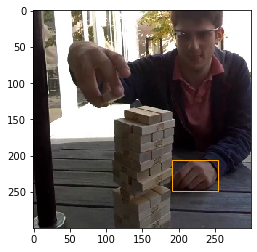

In [20]:
test_labels(ROOT_DIR)